***DCGAN 이란 ??***
- King - MAN + WOMAN = QUEEN ? 을 컴퓨터가 이해하기 위해선
    1) 단어의 의미를 이해하고
    2) 그에 맞는 새로운 단어를 찾는다는 고차원의 과정이 필요하게 된다.
    - **DCGAN**으로 이런 문제를 이미지에서도 해결할 수 있다.

- 생성 모델 연구에서 보여줘야 하는 내용 ?
    - Generator가 이미지를 외우는 것이 아니라는 것을 확인시켜 줘야 함
        (memorization이 일어난 것이 아니다라는 것. 즉, overffiting이 일어나서 1:1 matching을 하는 mapping을 배운게 아니라는 것을 보여줘야 함)
    - Generator의 input 공간인 Latent space(z space)에서 움직일 때 급작스러운 변화(shartp trasition)이 일어나는 것이 아닌 부드러운 변화를 보여줘야 한다


- 구조
    - max pooling과 같이 미분이 되지 않는 부분을 convolution으로 대체하여 all convolution net을 사용했다.
    - 마지막 FC layer를 쓰지 않았다.
        - why ?
            - weight(parameter)가 엄청나게 늘어나기 때문이라고 함(연산량 많아짐)
    - Batch Norm, Leaky ReLU를 사용했다



In [1]:
from __future__ import print_function
%matplotlib inline

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
#Set random seed for reproductibility(실행할 때마다 결과 달라지는 것 방지)
manualSeed = 999
print('Random seed:', manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random seed: 999


- dataroot - 데이터세트 폴더의 루트 경로
- workers - Dataloader를 이용해 데이터를 로드하기 위해 사용되는 스레드 수
- batch_size - 학습에서 사용되는 배치 크기. 논문에서는 128.
- image_size - 학습에서 사용되는 이미지 크기. (모든 이미지가 이 사이즈에 맞게 resize 된다.) 디폴트 값은 64 * 64. 다른 크기로 이용하기 위해서는 D(Discriminator)와 G(Generator)의 구조를 바꾸어야 한다.  자세한 사항은 이 곳에서 볼 수 있다.
- nc - 인풋 이미지의 색상 채널 수. 컬러 이미지는 이 값이 3이다. (*흑백 이미지의 경우 1)
- nz - 잠재 벡터의 길이(크기)
- ngf - Generator를 거치는 피쳐 맵의 크기
- gdf - Discriminator를 거치는 피쳐 맵의 크기
- num_epochs - training epoch의 수. 오랜 시간 학습하는 것이 더 좋은 결과를 낳지만, 더 오랜 시간이 걸릴 수 있다.
- lr - 학습에서 사용되는 learning rate. 논문에서는 0.0002
- beta1 - Adam optimizer를 위한 하이퍼파라미터이다. 논문에서는 0.5
- ngpu - 가능한 gpu의 수. 이 값이 0이라면 CPU 모드에서 작동할 것이다. 0보다 더 큰 수일 경우, 숫자만큼의 GPU에서 작동할 것이다.


출처: https://comlini8-8.tistory.com/7 [컴린이 탈출기 ver 2.0 ٩( ᐛ )و]

In [3]:
dataroot = 'img_align_celeba'
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 2
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [4]:
dataset = dset.ImageFolder(root = dataroot,
                          transform = transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True,
                                         num_workers = workers)
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

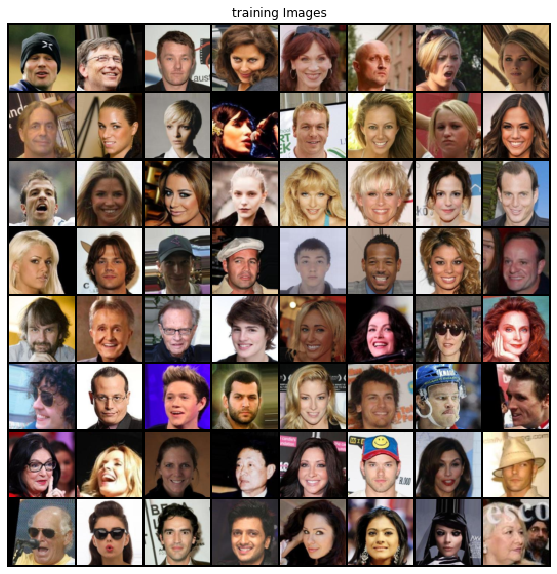

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize = (10, 10))
plt.axis("off")
plt.title("training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize = True).cpu(), (1, 2, 0)))

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Generator

class Generator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #input : Z벡터
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf*8, kernel_size = 4,
                               stride = 1, padding = 0, bias = 0),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            #state size : (ngf*8)*4*4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            #(ngf*4)*8*8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias = False),
            nn.Tanh()
            
            #nc * 64 * 64
        )
        
    def forward(self, input):
        return self.main(input)

In [8]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)
print(netG)
    

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
#Discriminator

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [10]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
criterion  = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device = device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas = (beta1, 0.999))

- Loss_D - 모든 진짜, 가짜 이미지 배치에 대한 loss를 합한 값
- Loss_G - log(D(G(z)))로 계산된 generator loss
- D(x) - 진짜 이미지 배치에 대한 discriminator의 평균 아웃풋. 1에 가깝게 시작해서, G가 나아질수록 이론적으로 0.5에 수렴하게 된다. 
- D(G(z)) - 가짜 이미지 배치에 대한 discriminator의 평균 아웃풋. 첫 번째 값은 D가 업데이트되기 전, 두 번째 값은 D가 업데이트된 후의 숫자이다. 이 숫자들은 0에 가깝게 시작해서 G가 나아질수록 0.5에 가깝게 된다.


출처: https://comlini8-8.tistory.com/7 [컴린이 탈출기 ver 2.0 ٩( ᐛ )و]

In [12]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

#for each epoch
for epoch in range(num_epochs):
    #for each batch
    for i, data in enumerate(dataloader, 0):
    
        #Update D
        
        #train with all-real bathc
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device = device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output.to(torch.float32), label.to(torch.float32))
        errD_real.backward()
        D_x = output.mean().item()
        
        #train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device = device)
        fake = netG(noise)
        label.fill_(fake_label)
        
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output.to(torch.float32), label.to(torch.float32))
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        
        optimizerD.step()
        
        #Update G
        netG.zero_grad()
        label.fill_(real_label)
        
        output = netD(fake).view(-1)
        errG = criterion(output.to(torch.float32), label.to(torch.float32))
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' %
                 (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding = 2, normailize = True))
                

Starting Training Loop...
[0/2][0/1583]	Loss_D: 2.1958	Loss_G: 4.9780	D(x): 0.5279	D(G(z)): 0.6894 / 0.0104
[0/2][50/1583]	Loss_D: 0.0829	Loss_G: 11.8010	D(x): 0.9471	D(G(z)): 0.0002 / 0.0000
[0/2][100/1583]	Loss_D: 0.4508	Loss_G: 6.5352	D(x): 0.8099	D(G(z)): 0.0159 / 0.0043
[0/2][150/1583]	Loss_D: 0.2781	Loss_G: 6.5543	D(x): 0.8300	D(G(z)): 0.0306 / 0.0036
[0/2][200/1583]	Loss_D: 0.8802	Loss_G: 9.2574	D(x): 0.9021	D(G(z)): 0.4443 / 0.0004
[0/2][250/1583]	Loss_D: 0.5184	Loss_G: 5.6702	D(x): 0.8725	D(G(z)): 0.2651 / 0.0062
[0/2][300/1583]	Loss_D: 1.2824	Loss_G: 3.0305	D(x): 0.3996	D(G(z)): 0.0218 / 0.0731
[0/2][350/1583]	Loss_D: 0.4395	Loss_G: 5.5488	D(x): 0.8890	D(G(z)): 0.2201 / 0.0085
[0/2][400/1583]	Loss_D: 0.8511	Loss_G: 8.4490	D(x): 0.9258	D(G(z)): 0.4631 / 0.0007
[0/2][450/1583]	Loss_D: 0.5431	Loss_G: 3.8432	D(x): 0.8016	D(G(z)): 0.2174 / 0.0386
[0/2][500/1583]	Loss_D: 0.3047	Loss_G: 3.7338	D(x): 0.9073	D(G(z)): 0.1224 / 0.0627
[0/2][550/1583]	Loss_D: 0.4556	Loss_G: 5.0759	D(x): 